In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4,InceptionV3
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Accuracy, BinaryAccuracy, Precision, Recall, AUC, SpecificityAtSensitivity
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def show_images(path, num_images, num_rows, num_cols):
    count = 0
    sizes = []
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for filename in os.listdir(path):
        if count < num_images and (filename.endswith(".jpg") or filename.endswith(".png")):
            img = Image.open(os.path.join(path, filename))
            img = img.convert('RGB')

            size = img.size
            sizes.append(size)

            row = count // num_cols
            col = count % num_cols
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            count += 1
        elif count >= num_images:
            break

    #avg_size = np.array(sizes).mean(axis=0)
    #avg_size = np.ceil(avg_size / 32) * 32
    #print("Average image size: ", avg_size)

    plt.show()

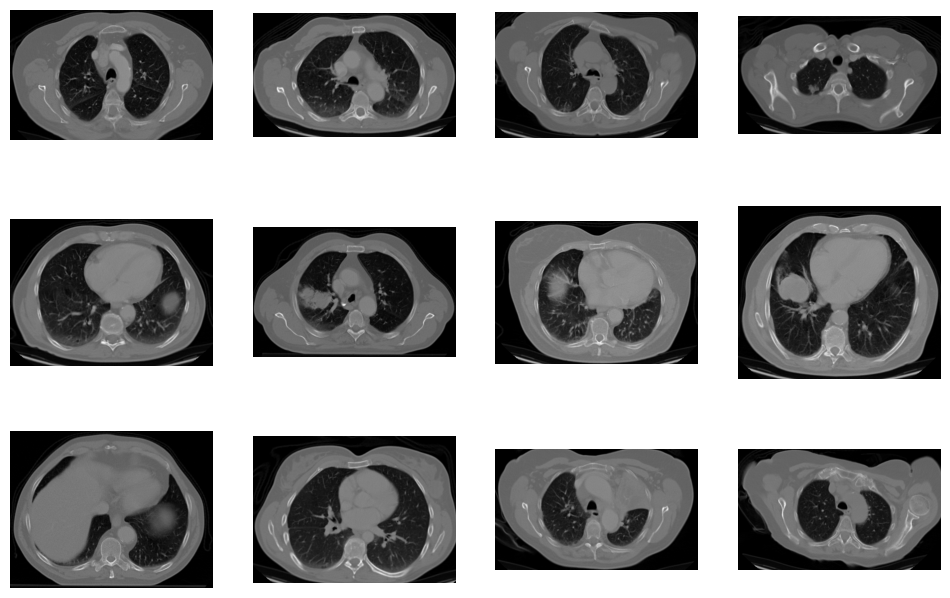

In [8]:
show_images("Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", 12, 3, 4)

#### Base models

In [9]:
def f_model(model):
    checkpoint = ModelCheckpoint('model.hdf5',verbose = 1, save_best_only=True)
    early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
    lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-5)

    metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
               FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
               Recall(name='recall'), AUC(name='auc'), SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')]

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3, beta_1 = 0.9, beta_2 = 0.999), metrics=metrics)
    history = model.fit(train_dataset, steps_per_epoch = 20, epochs = 100, verbose = 1, validation_data = valid_dataset,
                        callbacks = [checkpoint, early_stopping, lrd])
    return history

In [10]:
def plot_loss(x):
    plt.figure(figsize=(7, 5))
    plt.semilogy(x.epoch,  x.history['loss'], color='red',
                 label='Train Model')
    plt.semilogy(x.epoch,  x.history['val_loss'], color='blue',
                 label='Val Model', linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

In [11]:
def plot_metrics(x):
    metrics =  ['accuracy', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
    plt.figure(figsize=(10, 8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)
        plt.plot(x.epoch,  x.history[metric], color='red', label='Train')
        plt.plot(x.epoch, x.history['val_'+metric], color='blue', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
    plt.show()

In [12]:
train_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2, rotation_range=15,
                                   width_shift_range=0.1, height_shift_range=0.1, brightness_range=[0.4, 1.2],
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(dtype='float32', rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(dtype='float32', rescale = 1./255)

In [13]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (224,224), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (224,224), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (224,224), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [14]:
model1 = Sequential()
model1.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224,224,3), padding='same', activation='relu', data_format='channels_last'))
model1.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
model1.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

In [15]:
fm_1=f_model(model1)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.2136 - tp: 66.0000 - fp: 156.0000 - tn: 1683.0000 - fn: 547.0000 - accuracy: 0.7133 - precision: 0.2973 - recall: 0.1077 - auc: 0.5396 - sensitivity: 0.2262
Epoch 1: val_loss improved from inf to 1.40201, saving model to model.hdf5
20/20 [==============================] - 10s 421ms/step - loss: 2.2136 - tp: 66.0000 - fp: 156.0000 - tn: 1683.0000 - fn: 547.0000 - accuracy: 0.7133 - precision: 0.2973 - recall: 0.1077 - auc: 0.5396 - sensitivity: 0.2262 - val_loss: 1.4020 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6533 - val_sensitivity: 0.3241 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.3516 - tp: 26.0000 - fp: 8.0000 - tn: 1831.0000 - fn: 587.0000 - accuracy: 0.7573 - precision: 0.7647 - recall: 0.0424 - auc: 0.6591 - sensitivity: 0.3100
Epoch 2: val_loss

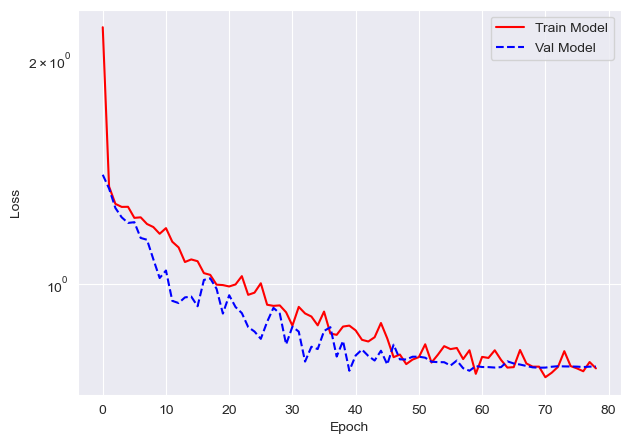

In [17]:
plot_loss(fm_1)

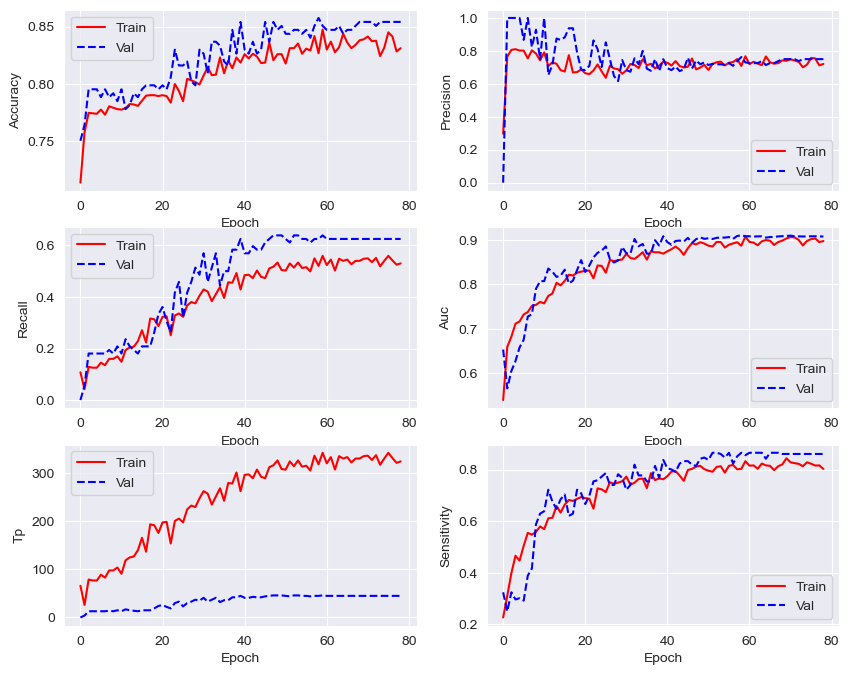

In [18]:
plot_metrics(fm_1)

In [19]:
result1 = model1.evaluate(test_dataset)

20/20 [==============================] - 1s 60ms/step - loss: 1.5529 - tp: 106.0000 - fp: 112.0000 - tn: 833.0000 - fn: 209.0000 - accuracy: 0.7452 - precision: 0.4862 - recall: 0.3365 - auc: 0.6868 - sensitivity: 0.4063


In [20]:
model2 = Sequential()
model2.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', activation='relu', data_format='channels_last'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.35))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      2336      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)           

In [22]:
fm_2=f_model(model2)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.1093 - tp: 183.0000 - fp: 109.0000 - tn: 1730.0000 - fn: 430.0000 - accuracy: 0.7802 - precision: 0.6267 - recall: 0.2985 - auc: 0.7857 - sensitivity: 0.6188
Epoch 1: val_loss improved from inf to 1.03484, saving model to model.hdf5
20/20 [==============================] - 10s 413ms/step - loss: 1.1093 - tp: 183.0000 - fp: 109.0000 - tn: 1730.0000 - fn: 430.0000 - accuracy: 0.7802 - precision: 0.6267 - recall: 0.2985 - auc: 0.7857 - sensitivity: 0.6188 - val_loss: 1.0348 - val_tp: 18.0000 - val_fp: 8.0000 - val_tn: 208.0000 - val_fn: 54.0000 - val_accuracy: 0.7847 - val_precision: 0.6923 - val_recall: 0.2500 - val_auc: 0.7890 - val_sensitivity: 0.5648 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.0568 - tp: 119.0000 - fp: 41.0000 - tn: 1798.0000 - fn: 494.0000 - accuracy: 0.7818 - precision: 0.7438 - recall: 0.1941 - auc: 0.8033 - sensitivity: 0.6531
Epoch 2: val_loss did not im

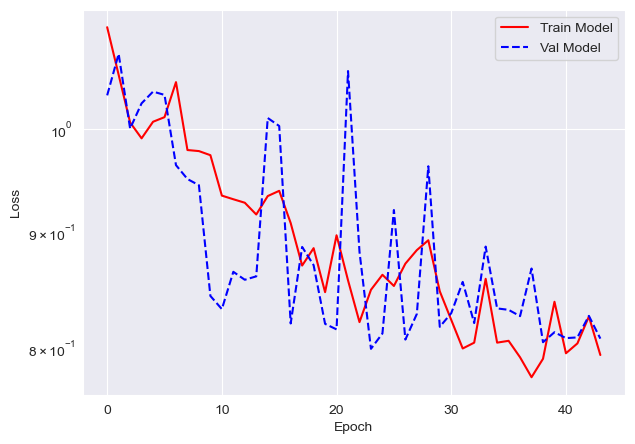

In [23]:
plot_loss(fm_2)

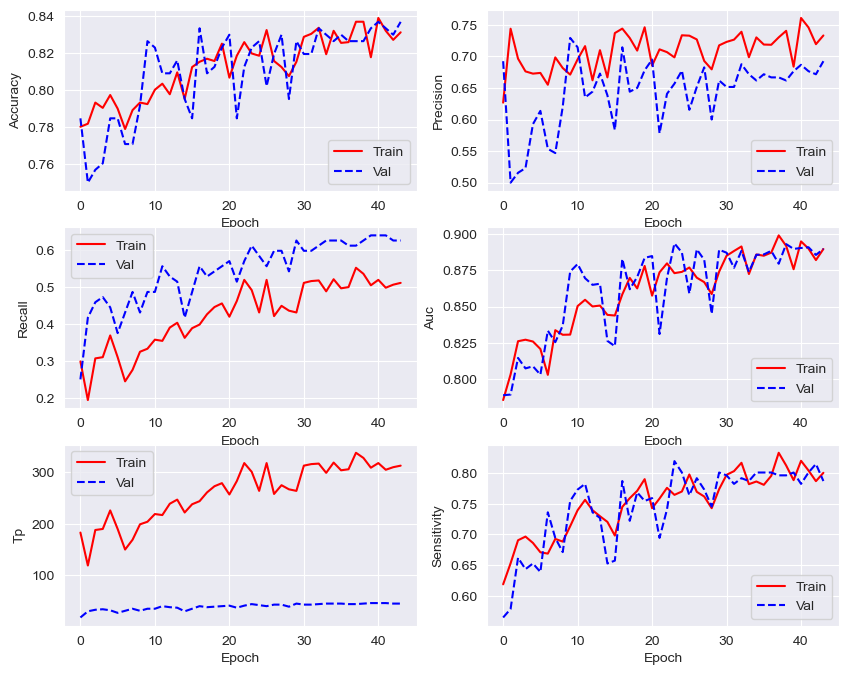

In [24]:
plot_metrics(fm_2)

In [25]:
result2 = model2.evaluate(test_dataset)

20/20 [==============================] - 1s 55ms/step - loss: 1.3959 - tp: 101.0000 - fp: 94.0000 - tn: 851.0000 - fn: 214.0000 - accuracy: 0.7556 - precision: 0.5179 - recall: 0.3206 - auc: 0.7102 - sensitivity: 0.4508


In [26]:
model3 = Sequential()

model3.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', data_format='channels_last'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))

model3.add(Flatten())
model3.add(Dense(256, kernel_regularizer = regularizers.l2(1e-3)))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2336      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)    

In [27]:
fm_3=f_model(model3)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 40.2181 - tp: 217.0000 - fp: 384.0000 - tn: 1455.0000 - fn: 396.0000 - accuracy: 0.6819 - precision: 0.3611 - recall: 0.3540 - auc: 0.5836 - sensitivity: 0.2012
Epoch 1: val_loss improved from inf to 2.16261, saving model to model.hdf5
20/20 [==============================] - 9s 407ms/step - loss: 40.2181 - tp: 217.0000 - fp: 384.0000 - tn: 1455.0000 - fn: 396.0000 - accuracy: 0.6819 - precision: 0.3611 - recall: 0.3540 - auc: 0.5836 - sensitivity: 0.2012 - val_loss: 2.1626 - val_tp: 12.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 60.0000 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.1667 - val_auc: 0.7034 - val_sensitivity: 0.4352 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 6.0002 - tp: 155.0000 - fp: 224.0000 - tn: 1615.0000 - fn: 458.0000 - accuracy: 0.7219 - precision: 0.4090 - recall: 0.2529 - auc: 0.6256 - sensitivity: 0.3290
Epoch 2: val_loss did 

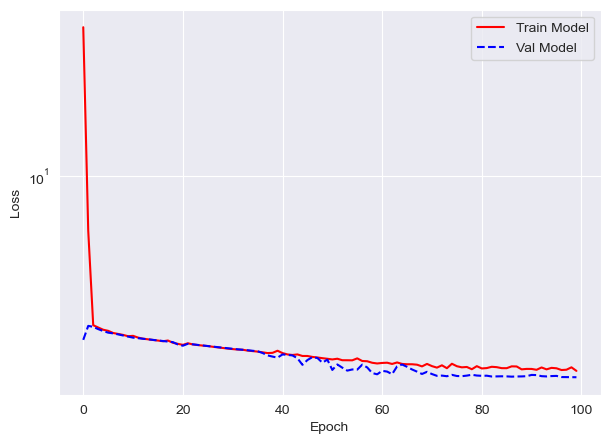

In [28]:
plot_loss(fm_3)

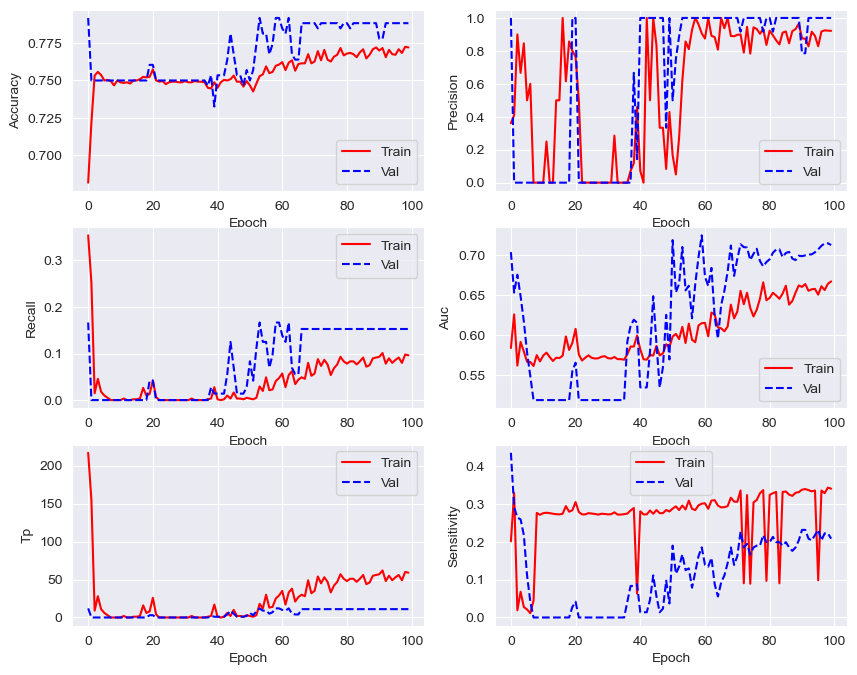

In [29]:
plot_metrics(fm_3)

In [30]:
result3 = model3.evaluate(test_dataset)

20/20 [==============================] - 1s 58ms/step - loss: 1.6569 - tp: 42.0000 - fp: 31.0000 - tn: 914.0000 - fn: 273.0000 - accuracy: 0.7587 - precision: 0.5753 - recall: 0.1333 - auc: 0.6726 - sensitivity: 0.2455


In [31]:
model4 = Sequential()

model4.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', data_format='channels_last'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(16, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Dropout(0.4))
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(4, activation='softmax'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 batch_normalization_2 (Batc  (None, 224, 224, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 batch_normalization_3 (Batc  (None, 112, 112, 16)    

In [32]:
fm_4 = f_model(model4)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 15.0963 - tp: 199.0000 - fp: 400.0000 - tn: 1439.0000 - fn: 414.0000 - accuracy: 0.6680 - precision: 0.3322 - recall: 0.3246 - auc: 0.5779 - sensitivity: 0.0680
Epoch 1: val_loss improved from inf to 1.48313, saving model to model.hdf5
20/20 [==============================] - 10s 417ms/step - loss: 15.0963 - tp: 199.0000 - fp: 400.0000 - tn: 1439.0000 - fn: 414.0000 - accuracy: 0.6680 - precision: 0.3322 - recall: 0.3246 - auc: 0.5779 - sensitivity: 0.0680 - val_loss: 1.4831 - val_tp: 17.0000 - val_fp: 25.0000 - val_tn: 191.0000 - val_fn: 55.0000 - val_accuracy: 0.7222 - val_precision: 0.4048 - val_recall: 0.2361 - val_auc: 0.6241 - val_sensitivity: 0.2500 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.5313 - tp: 137.0000 - fp: 194.0000 - tn: 1645.0000 - fn: 476.0000 - accuracy: 0.7268 - precision: 0.4139 - recall: 0.2235 - auc: 0.6250 - sensitivity: 0.3344
Epoch 2: val_loss improv

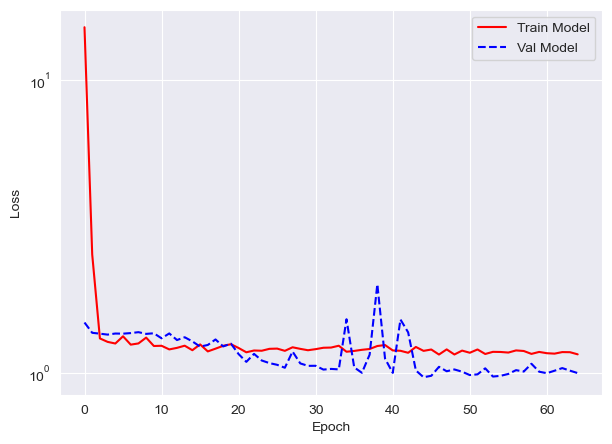

In [33]:
plot_loss(fm_4)

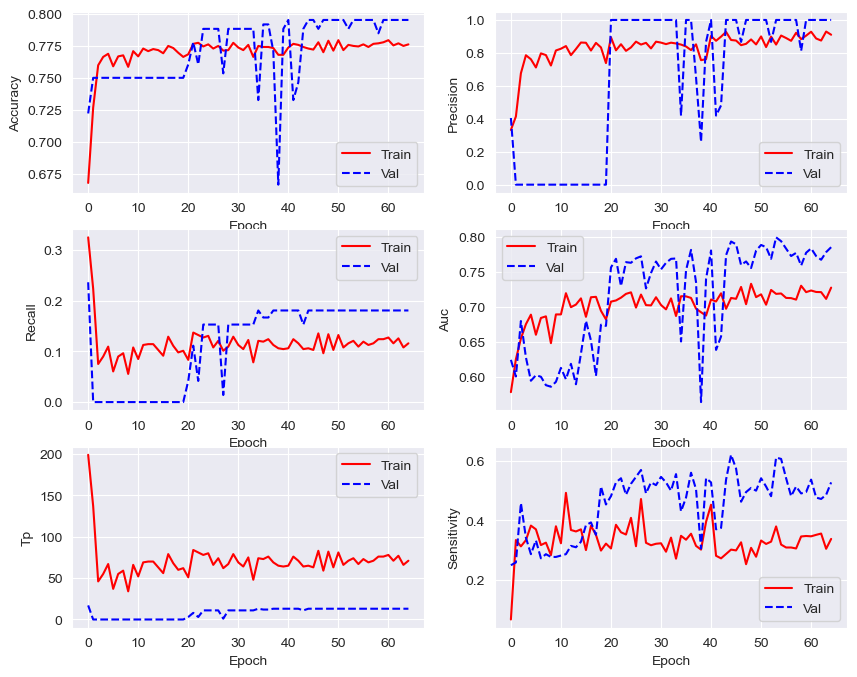

In [34]:
plot_metrics(fm_4)

In [36]:
result4 = model4.evaluate(test_dataset)

20/20 [==============================] - 1s 53ms/step - loss: 1.0913 - tp: 53.0000 - fp: 10.0000 - tn: 935.0000 - fn: 262.0000 - accuracy: 0.7841 - precision: 0.8413 - recall: 0.1683 - auc: 0.7718 - sensitivity: 0.5503


In [37]:
model5 = Sequential()

model5.add(Conv2D(8, kernel_size=(3, 3), input_shape=(224, 224,3), padding='same', data_format='channels_last'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer = regularizers.l2(1e-3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Dense(128, kernel_regularizer = regularizers.l2(1e-3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Dropout(0.4))
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(4, activation='softmax'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      2336      
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 32)    

In [38]:
fm_5 = f_model(model5)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 17.9384 - tp: 224.0000 - fp: 344.0000 - tn: 1495.0000 - fn: 389.0000 - accuracy: 0.7011 - precision: 0.3944 - recall: 0.3654 - auc: 0.6055 - sensitivity: 0.1022
Epoch 1: val_loss improved from inf to 1.44725, saving model to model.hdf5
20/20 [==============================] - 10s 399ms/step - loss: 17.9384 - tp: 224.0000 - fp: 344.0000 - tn: 1495.0000 - fn: 389.0000 - accuracy: 0.7011 - precision: 0.3944 - recall: 0.3654 - auc: 0.6055 - sensitivity: 0.1022 - val_loss: 1.4472 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5409 - val_sensitivity: 0.1898 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.6803 - tp: 51.0000 - fp: 22.0000 - tn: 1817.0000 - fn: 562.0000 - accuracy: 0.7618 - precision: 0.6986 - recall: 0.0832 - auc: 0.6190 - sensitivity: 0.1321
Epoch 2: val

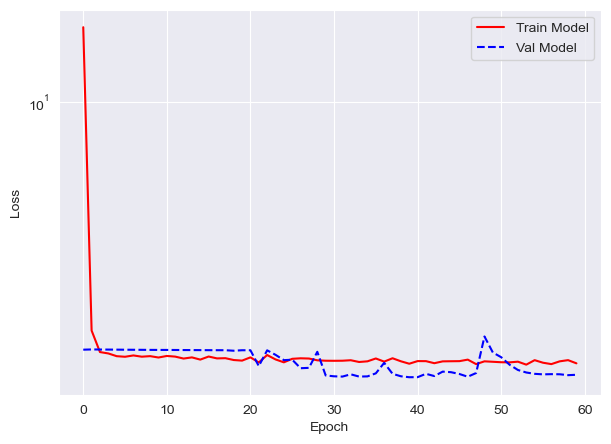

In [44]:
plot_loss(fm_5)

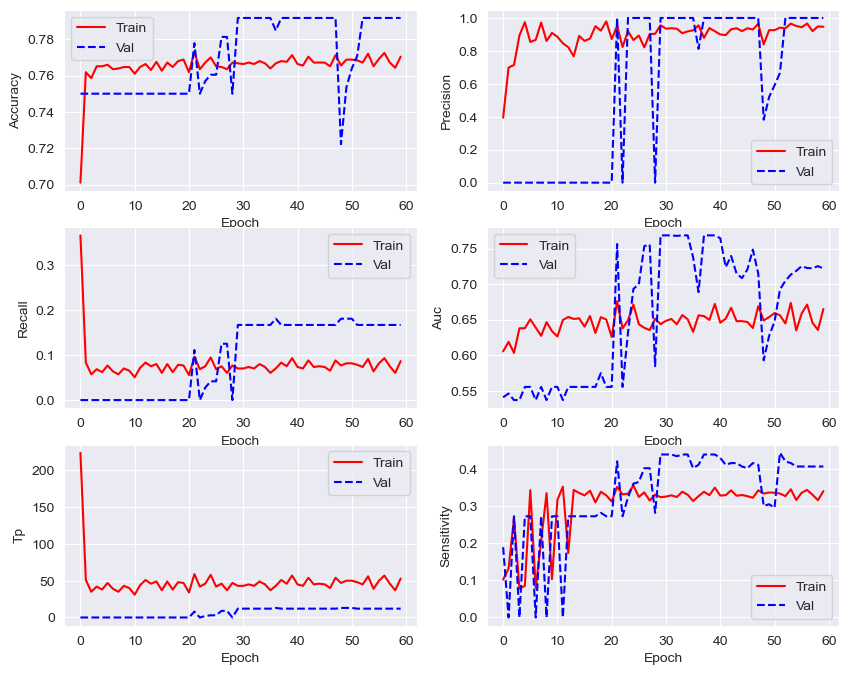

In [45]:
plot_metrics(fm_5)

In [46]:
result5 = model5.evaluate(test_dataset)

20/20 [==============================] - 1s 55ms/step - loss: 1.1916 - tp: 44.0000 - fp: 1.0000 - tn: 944.0000 - fn: 271.0000 - accuracy: 0.7841 - precision: 0.9778 - recall: 0.1397 - auc: 0.7568 - sensitivity: 0.6275


In [47]:
model6 = Sequential()
model6.add(Conv2D(16, kernel_size=(5, 5), input_shape=(224, 224,3), padding='same', activation='relu', data_format='channels_last'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.35))

model6.add(Flatten())
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.5))
model6.add(Dense(4, activation='softmax'))

model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 64)      9280      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 56, 56, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 200704)           

In [48]:
fm_6 = f_model(model6)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.8379 - tp: 68.0000 - fp: 111.0000 - tn: 1728.0000 - fn: 545.0000 - accuracy: 0.7325 - precision: 0.3799 - recall: 0.1109 - auc: 0.5762 - sensitivity: 0.2795
Epoch 1: val_loss improved from inf to 1.33575, saving model to model.hdf5
20/20 [==============================] - 11s 480ms/step - loss: 1.8379 - tp: 68.0000 - fp: 111.0000 - tn: 1728.0000 - fn: 545.0000 - accuracy: 0.7325 - precision: 0.3799 - recall: 0.1109 - auc: 0.5762 - sensitivity: 0.2795 - val_loss: 1.3358 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 72.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6666 - val_sensitivity: 0.1991 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.2604 - tp: 49.0000 - fp: 14.0000 - tn: 1825.0000 - fn: 564.0000 - accuracy: 0.7643 - precision: 0.7778 - recall: 0.0799 - auc: 0.7061 - sensitivity: 0.4421
Epoch 2: val_los

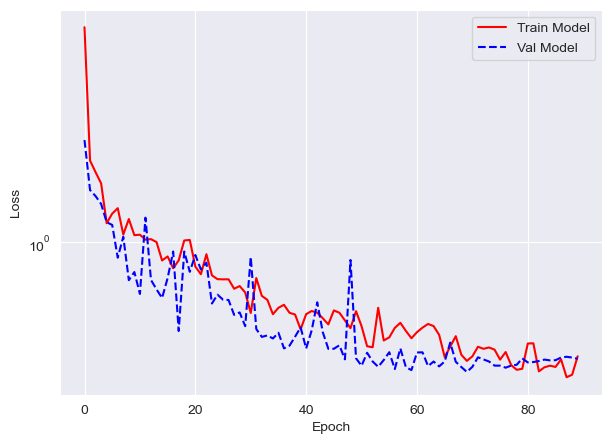

In [49]:
plot_loss(fm_6)

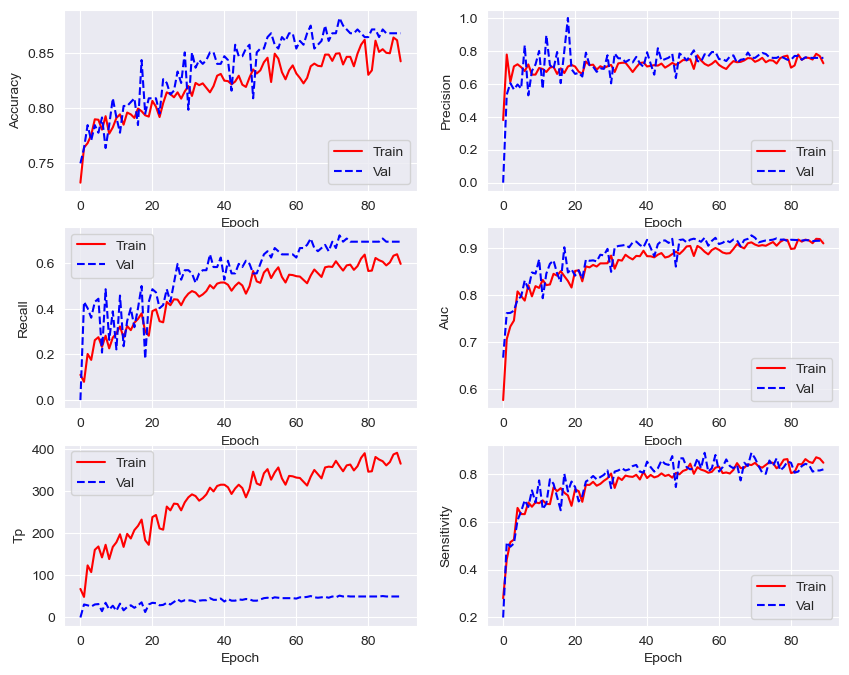

In [50]:
plot_metrics(fm_6)

In [51]:
result6 = model6.evaluate(test_dataset)

20/20 [==============================] - 1s 66ms/step - loss: 1.5830 - tp: 111.0000 - fp: 144.0000 - tn: 801.0000 - fn: 204.0000 - accuracy: 0.7238 - precision: 0.4353 - recall: 0.3524 - auc: 0.7201 - sensitivity: 0.4921


## Transfer Learning

### InceptionV3

In [52]:
from keras.applications.inception_v3 import preprocess_input

def my_preprocess_input(x):
    x = preprocess_input(x)
    return x

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=my_preprocess_input)

In [53]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (299,299), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (299,299), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (299,299), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [54]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299, 3))
for layer in inception_model.layers:
    layer.trainable = False

In [62]:
model7 = Sequential()
model7.add(inception_model)
model7.add(Conv2D(16, kernel_size=(5, 5), input_shape=(299, 299,3), padding='same', activation='relu', data_format='channels_last'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.35))

model7.add(Flatten())
model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.5))
model7.add(Dense(4, activation='softmax'))

model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_109 (Conv2D)         (None, 8, 8, 16)          819216    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_110 (Conv2D)         (None, 4, 4, 64)          9280      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 2, 2, 64)         

In [63]:
fm_7 = f_model(model7)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3951 - tp: 36.0000 - fp: 57.0000 - tn: 1782.0000 - fn: 577.0000 - accuracy: 0.7414 - precision: 0.3871 - recall: 0.0587 - auc: 0.5869 - sensitivity: 0.3029
Epoch 1: val_loss improved from inf to 1.24817, saving model to model.hdf5
20/20 [==============================] - 21s 858ms/step - loss: 1.3951 - tp: 36.0000 - fp: 57.0000 - tn: 1782.0000 - fn: 577.0000 - accuracy: 0.7414 - precision: 0.3871 - recall: 0.0587 - auc: 0.5869 - sensitivity: 0.3029 - val_loss: 1.2482 - val_tp: 8.0000 - val_fp: 5.0000 - val_tn: 211.0000 - val_fn: 64.0000 - val_accuracy: 0.7604 - val_precision: 0.6154 - val_recall: 0.1111 - val_auc: 0.7054 - val_sensitivity: 0.3750 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.1616 - tp: 96.0000 - fp: 75.0000 - tn: 1764.0000 - fn: 517.0000 - accuracy: 0.7586 - precision: 0.5614 - recall: 0.1566 - auc: 0.7646 - sensitivity: 0.6351
Epoch 2: val_loss improved from 1.

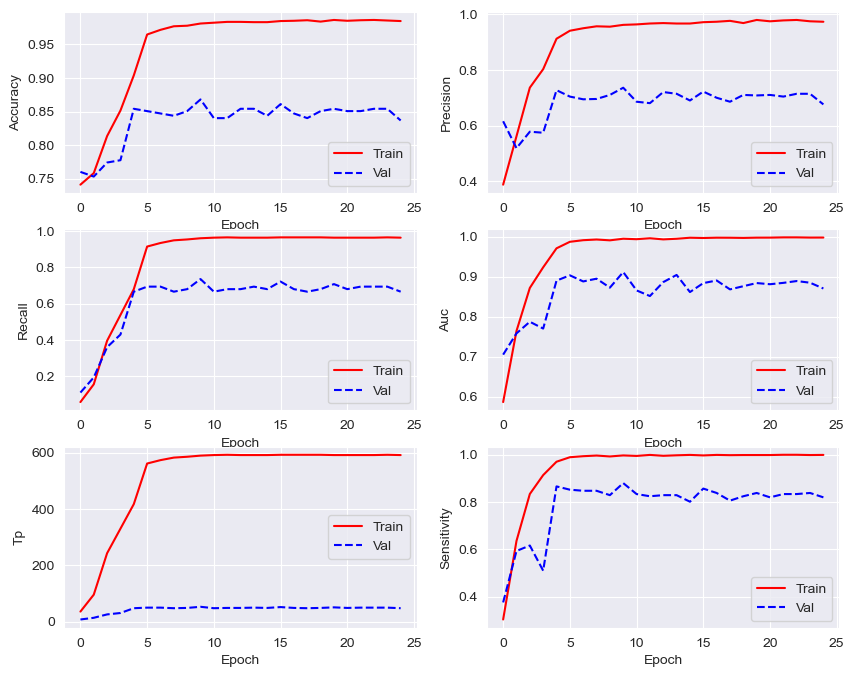

In [65]:
plot_metrics(fm_7)

In [66]:
result7 = model7.evaluate(test_dataset)

20/20 [==============================] - 3s 126ms/step - loss: 1.4497 - tp: 193.0000 - fp: 117.0000 - tn: 828.0000 - fn: 122.0000 - accuracy: 0.8103 - precision: 0.6226 - recall: 0.6127 - auc: 0.8482 - sensitivity: 0.7820


### ResNet50

In [73]:

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [74]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (224,224), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (224,224), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (224,224), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [75]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in resnet_model.layers:
    layer.trainable = False

In [76]:
model8 = Sequential()
model8.add(resnet_model)
model8.add(Conv2D(16, kernel_size=(5, 5), input_shape=(224,224,3), padding='same', activation='relu', data_format='channels_last'))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Dropout(0.35))
model8.add(Flatten())
model8.add(Dense(256, activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(4, activation='softmax'))

model8.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_111 (Conv2D)         (None, 7, 7, 16)          819216    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_112 (Conv2D)         (None, 3, 3, 64)          9280      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 1, 1, 64)         

In [77]:
fm_8 = f_model(model8)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.5635 - tp: 63.0000 - fp: 104.0000 - tn: 1735.0000 - fn: 550.0000 - accuracy: 0.7333 - precision: 0.3772 - recall: 0.1028 - auc: 0.5714 - sensitivity: 0.2594
Epoch 1: val_loss improved from inf to 1.16885, saving model to model.hdf5
20/20 [==============================] - 10s 348ms/step - loss: 1.5635 - tp: 63.0000 - fp: 104.0000 - tn: 1735.0000 - fn: 550.0000 - accuracy: 0.7333 - precision: 0.3772 - recall: 0.1028 - auc: 0.5714 - sensitivity: 0.2594 - val_loss: 1.1688 - val_tp: 11.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 61.0000 - val_accuracy: 0.7882 - val_precision: 1.0000 - val_recall: 0.1528 - val_auc: 0.7544 - val_sensitivity: 0.4722 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.0802 - tp: 172.0000 - fp: 52.0000 - tn: 1787.0000 - fn: 441.0000 - accuracy: 0.7989 - precision: 0.7679 - recall: 0.2806 - auc: 0.7918 - sensitivity: 0.6058
Epoch 2: val_loss improved

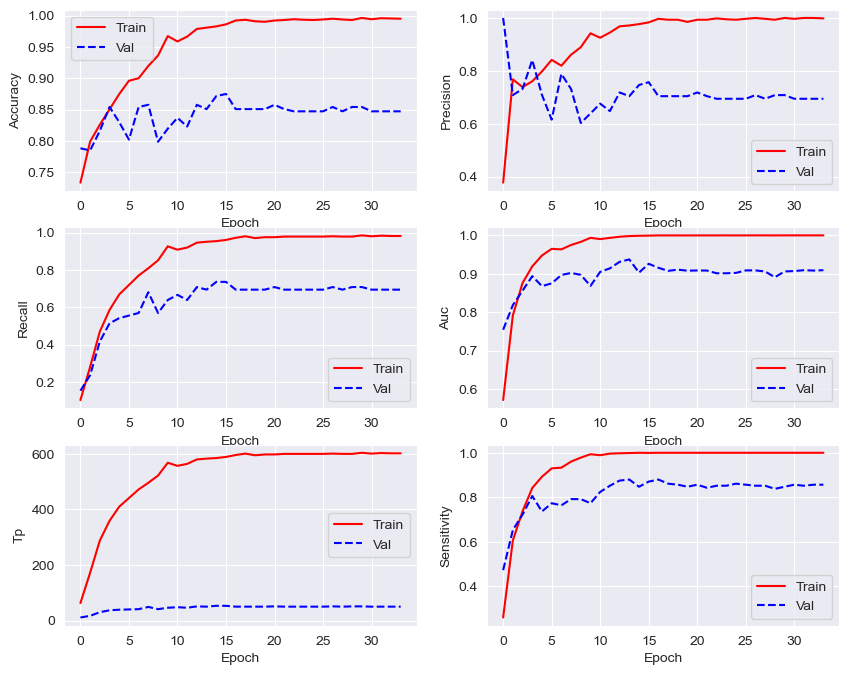

In [79]:
plot_metrics(fm_8)

In [80]:
result8 = model8.evaluate(test_dataset)

20/20 [==============================] - 3s 117ms/step - loss: 1.8351 - tp: 204.0000 - fp: 111.0000 - tn: 834.0000 - fn: 111.0000 - accuracy: 0.8238 - precision: 0.6476 - recall: 0.6476 - auc: 0.8580 - sensitivity: 0.8190


### VGG19

In [81]:
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [82]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Data/train', target_size = (224,224), class_mode = 'categorical', batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = 'Data/valid', target_size = (224,224), class_mode = 'categorical', batch_size = 8)

test_dataset = test_datagen.flow_from_directory(directory = 'Data/test', target_size = (224,224), class_mode = 'categorical', batch_size = 16)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [83]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in vgg19_model.layers:
    layer.trainable = False

In [84]:
model9 = Sequential()
model9.add(vgg19_model)
model9.add(Conv2D(16, kernel_size=(5, 5), input_shape=(224,224,3), padding='same', activation='relu', data_format='channels_last'))
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer = regularizers.l2(1e-3), bias_regularizer= regularizers.l1(1e-3)))
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Dropout(0.35))
model9.add(Flatten())
model9.add(Dense(256, activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(4, activation='softmax'))

model9.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_113 (Conv2D)         (None, 7, 7, 16)          204816    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 3, 3, 64)          9280      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 1, 1, 64)        

In [85]:
fm_9 = f_model(model9)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.2607 - tp: 147.0000 - fp: 220.0000 - tn: 1619.0000 - fn: 466.0000 - accuracy: 0.7202 - precision: 0.4005 - recall: 0.2398 - auc: 0.6169 - sensitivity: 0.3382
Epoch 1: val_loss improved from inf to 1.18909, saving model to model.hdf5
20/20 [==============================] - 15s 691ms/step - loss: 2.2607 - tp: 147.0000 - fp: 220.0000 - tn: 1619.0000 - fn: 466.0000 - accuracy: 0.7202 - precision: 0.4005 - recall: 0.2398 - auc: 0.6169 - sensitivity: 0.3382 - val_loss: 1.1891 - val_tp: 12.0000 - val_fp: 0.0000e+00 - val_tn: 216.0000 - val_fn: 60.0000 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.1667 - val_auc: 0.7104 - val_sensitivity: 0.4074 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.0915 - tp: 160.0000 - fp: 38.0000 - tn: 1801.0000 - fn: 453.0000 - accuracy: 0.7998 - precision: 0.8081 - recall: 0.2610 - auc: 0.7748 - sensitivity: 0.5590
Epoch 2: val_loss improv

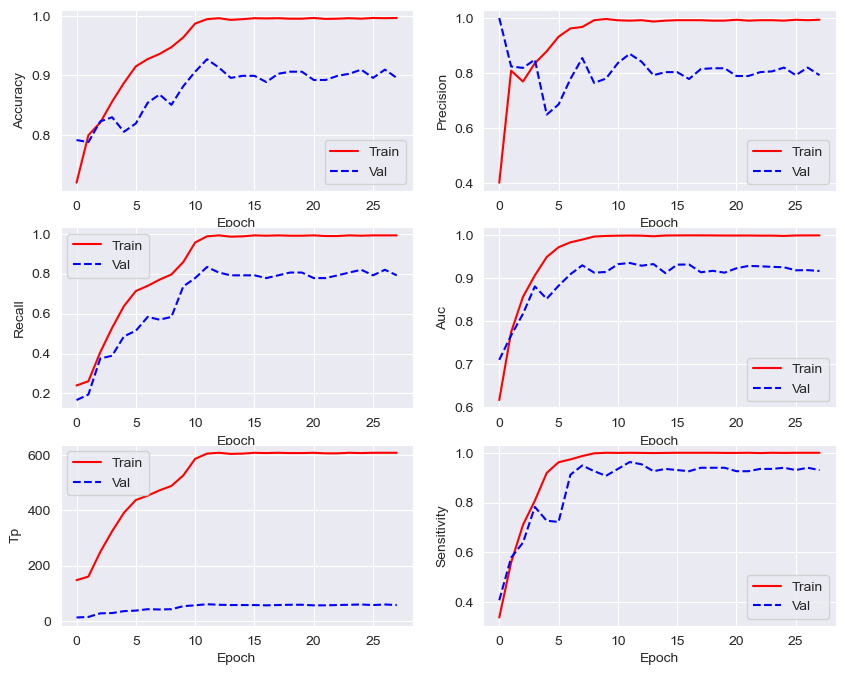

In [87]:
plot_metrics(fm_9)

In [88]:
result9 = model9.evaluate(test_dataset)

20/20 [==============================] - 6s 297ms/step - loss: 0.8536 - tp: 231.0000 - fp: 77.0000 - tn: 868.0000 - fn: 84.0000 - accuracy: 0.8722 - precision: 0.7500 - recall: 0.7333 - auc: 0.9215 - sensitivity: 0.8868
